# Plot feature permutation importance (FPI) results

This notebook will visualize/consolidate the FPI results of the machine learning runs (organized in different branches) in this repositiory.

In [ ]:
# Uncomment if you need to install packages.
#! conda install -y pandas numpy matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv

# Define the repository url to work with and prefix for where it will be copied.
repo_prefix = '~/tmp/'

org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+org+'/'+repo_name

# Set all font sizes in the plots
font = {'family' : 'sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

## Setup - setting the context 

Since the ML runs are on different branches, we need to jump from branch-to-branch and gather and plot data along the way. This setup cell specifies the branches and the ordering of the features for the FPI diagram.

In [2]:
# Make a list of which branches to operate on.
# ASSUME that the first branch will have the most
# complete list of features (i.e. inputs) to the ML
# models. This first list of features will be
# used to create a look-up table for feature-to-feature
# comparisons/visulizations later.

list_branches = [
    'Dec-2021a-log10',
    'Dec-2021b-log10',
    'Jul-2022-log10',
    'Aug-2022-log10',
    'Sep-2022-log10',
    'Oct-2022-log10',
    'Nov-2022-log10',
    'Dec-2022-log10',
    'Jan-2023-log10',
    'Feb-2023-log10',
    'Mar-2023-log10',
    'Apr-2023-log10',
    'May-2023-log10',
    'June-2023-log10',
    'Jul-2023-log10',
    'August-2023-log10',
    'Sep-2023-log10',
    'Oct-2023-log10',
    'Nov-2023-log10-DO-update-correct']

list_colors = ['k','r','g','b']
fpi_max = 0.0
alpha_overlay = 0.1

# Initialize empty dataframes
# for model scores and histograms
model_scores = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
train_hist = pd.DataFrame(columns=list_branches)
predict_hist = pd.DataFrame(columns=list_branches)
test_hist = pd.DataFrame(columns=list_branches)

# Initialize empty list to overlay plot of means
scatter_id = []
scatter_mean = []
scatter_size = []
scatter_color = []

print("Clone and build feature integer ID lookup table...")
! mkdir -p {repo_prefix}
! cd {repo_prefix}; git clone {repo_url}
! mkdir -p ./intermediate_branch_data
        
# Load data for look up table only
# Originally, we loaded an FPI file directly
# from the ML archive. But, since we want
# explicit control over the ordering of
# the features in the final plot, here we
# specify a file.
#
# This particular file was created with the
# FPI summary writing code at the end of this
# notebook and can be cross checked with the
# corresponding file in ./intermediate_branch_data
fpi_avg = pd.read_csv('FPI_summary_table_Nov-2023-log10-DO-update-correct.csv', index_col=False)
     
# Make the look up table; need to invert
# the keys (integers) with the values (feature names)
# so that feature names can be converted to ints
# later.
# Note that we want to flip the figure so that the
# scores with the highest FPI are at the top of the
# figure, so use (24-k) instead of (k) for the ID
# in the feature_id_name_dict.
feature_id_name_dict = dict((v,(24-k)) for k,v in fpi_avg['Unnamed: 0'].to_dict().items())
        
# Print the lookup table for cross-checking
print("Feature : ID")
for kk in feature_id_name_dict.keys():
    print(kk+": "+str(feature_id_name_dict[kk]))
        
# Unload the data b/c later we will want to use the index
#del fpi_avg

Clone and build feature integer ID lookup table...
fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.
Feature : ID
ele_mt_cav: 24
Mean_Temp_Deg_C: 23
for_pc_cse: 22
crp_pc_cse: 21
Mean_DO_mg_per_L: 20
Mean_DO_percent_saturation: 19
gwt_cm_cav: 18
slp_dg_cav: 17
ire_pc_cse: 16
tmp_dc_cyr: 15
RA_dm: 14
RA_SO: 13
RA_ms_av: 12
RA_ms_di: 11
pre_mm_cyr: 10
run_mm_cyr: 9
tmp_dc_cdi: 8
pre_mm_cdi: 7
pst_pc_cse: 6
pH: 5
sgr_dk_rav: 4
ppd_pk_cav: 3
dor_pc_pva: 2
prm_pc_cse: 1
gla_pc_cse: 0


## Grab data and plot on the fly

Updating files: 100% (348/348), done.
Switched to branch 'Dec-2021a-log10'
Your branch is up to date with 'origin/Dec-2021a-log10'.
Updating files: 100% (327/327), done.
Switched to branch 'Dec-2021b-log10'
Your branch is up to date with 'origin/Dec-2021b-log10'.
Updating files: 100% (344/344), done.
Switched to branch 'Jul-2022-log10'
Your branch is up to date with 'origin/Jul-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Aug-2022-log10'
Your branch is up to date with 'origin/Aug-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Sep-2022-log10'
Your branch is up to date with 'origin/Sep-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Oct-2022-log10'
Your branch is up to date with 'origin/Oct-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Nov-2022-log10'
Your branch is up to date with 'origin/Nov-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Dec-2022-log10'
Your branch 

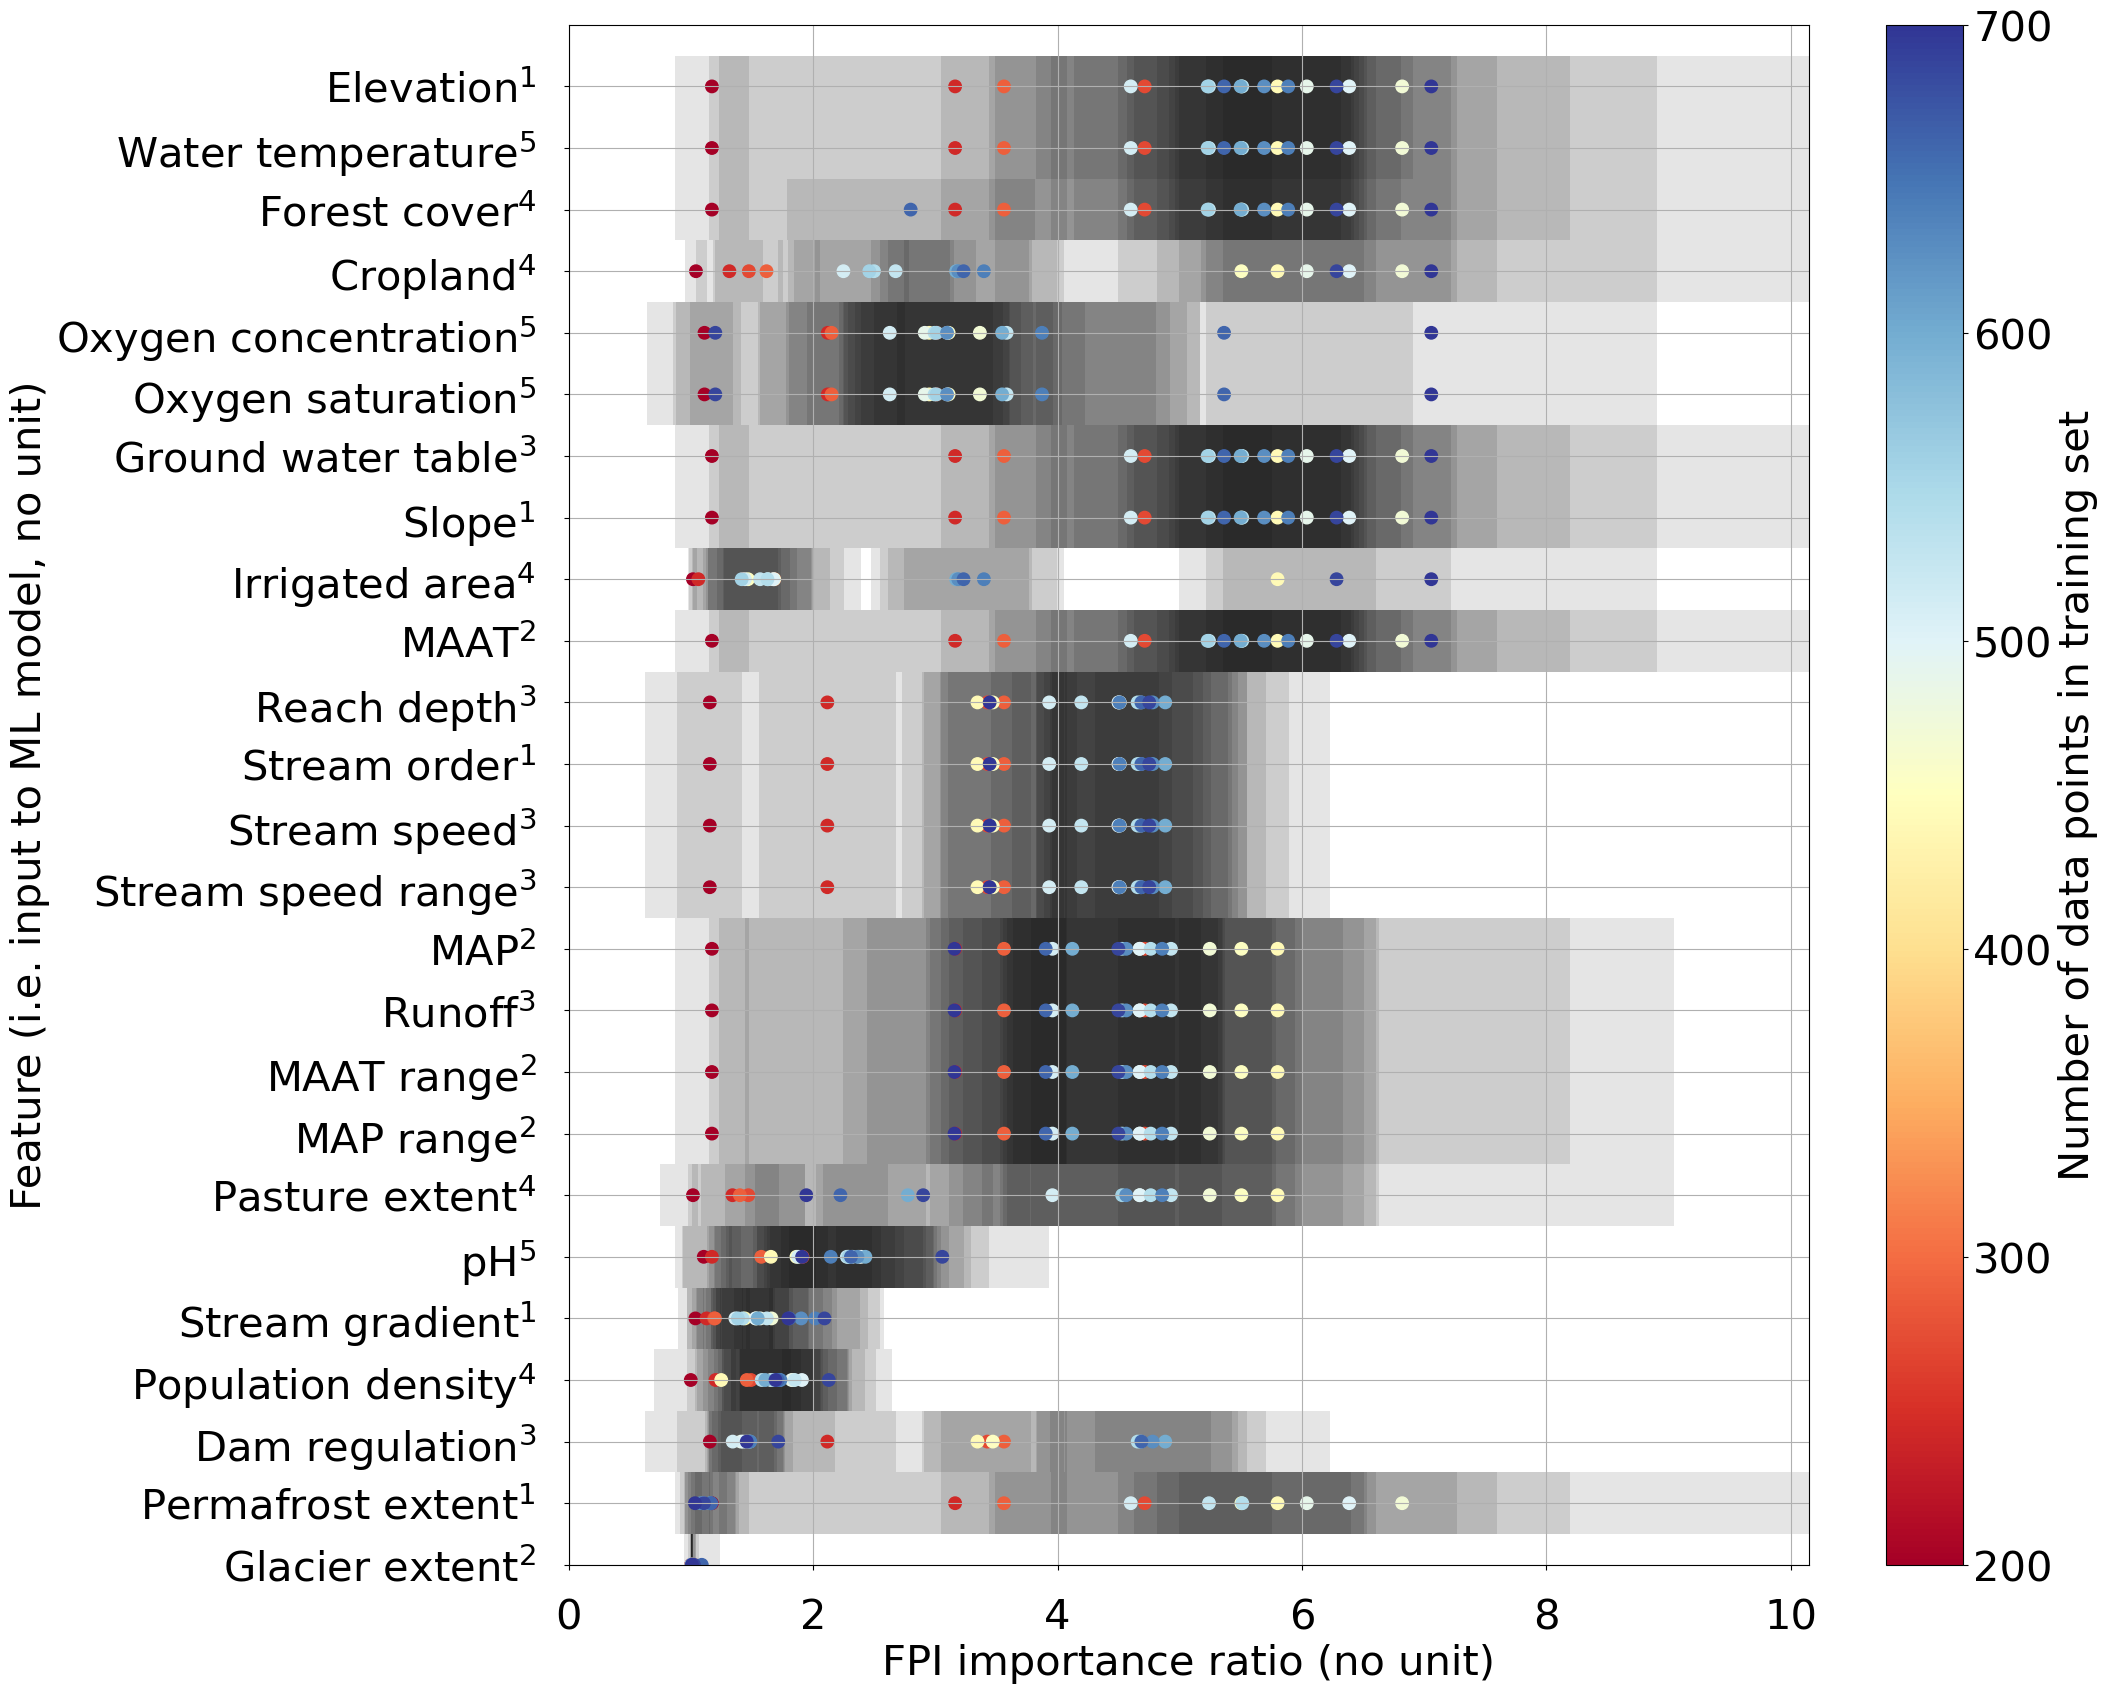

In [3]:
# Initialize a plot
fig, ax = plt.subplots(1,1,figsize=(20,20))
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(200, 700), cmap='RdYlBu'),
             ax=ax, orientation='vertical', label='Number of data points in training set')
#colormap = plt.cm.get_cmap('RdYlBu')

for ll,branch in enumerate(list_branches):
    
    # Set up is complete from cell above; just change to branches
    ! cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # Load data and replace feature names with IDs in dict
    # In the process, get a list of features available in
    # just this branch.
    fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=0)
    branch_feature_names = list(fpi_avg.index)
    fpi_avg.rename(index=feature_id_name_dict, inplace=True)
    
    fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv', index_col=0)
    fpi_std.rename(index=feature_id_name_dict, inplace=True)
    
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    mean = fpi_avg.mean(axis=1)
    upper = fpi_avg.mean(axis=1)+fpi_avg.std(axis=1)
    lower = fpi_avg.mean(axis=1)-fpi_avg.std(axis=1)
    error = fpi_std.max(axis=1)
    
    # If the max value is bigger than the current value,
    # update it.
    if upper.max() > fpi_max:
        fpi_max = upper.max()
    
    # Load model scores
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # RAW DATA
    #input_data = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED DATA (actually used)
    input_data = pd.read_csv(repo_prefix+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    model_scores.loc[len(model_scores.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # Grab histograms of the distribution of the target to
    # assess bias in the ML models
    train_all = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    train_hist[branch] = train_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    # Need to grab predictions at observed sites at a deeper level
    # than the main output files; filter for only the observed sites.
    test_all = pd.read_csv(repo_prefix+repo_name+'/scripts/post_01_output_ml_predict_avg.csv',index_col='Sample_ID')
    test_all = test_all.filter(axis='index', regex="S19S|SSS|CM_")
    test_hist[branch] = test_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    predict_all = pd.read_csv(repo_prefix+repo_name+'/output_data/filtered_predict_output.csv')
    predict_hist[branch] = predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
    # Plot a box for each feature. We work feature by feature
    # because not all features will be available and not all
    # are chopped out from the edges either; sometimes features
    # will be chopped out from the middle so we don't want to
    # plot continuous lines.
    
    # Also, print out good features:
    #print('Significant features for the ML model on this branch:')
    ff = 1
    for feature in branch_feature_names:
        # Get feature ID from the dict
        f_id = feature_id_name_dict[feature]
        
        # Get the center of the box
        f_mean = mean[f_id]
        
        # Get the upper and lower bounds of the box
        f_upper = upper[f_id] 
        f_lower = lower[f_id]
        f_error = error[f_id]
        
        # For debugging the plot and cross-checking values
        #print('id: '+str(f_id)+' name: '+feature+' mean: '+str(f_mean)) 
        
        # Rectangles with x=feature_id, y=fpi_score
        #left, bottom, width, height = (f_id - 0.5, f_lower, 1.0, f_upper-f_lower)
        
        # FLIPPED Rectangles with x=fpi_score, y=feature_id (can print feature name in figure)
        left, bottom, width, height = (f_lower, f_id - 0.5, f_upper-f_lower, 1.0)
        
        rect = plt.Rectangle((left, bottom), width, height,
            facecolor='k', alpha=alpha_overlay)
        
        # Add collection to axes
        ax.add_patch(rect)
        
        # Plot means
        # As black dots...
        #ax.plot(f_id,f_mean,'ko')
        # ...or as scatter color coded by number of samples
        # But don't do this here because gets overlaid by
        # translucent rectangles. So store data and plot
        # all at once later
        #ax.scatter(f_id,f_mean,10,len(input_data.index))
        scatter_id.append(f_id)
        scatter_mean.append(f_mean)
        scatter_size.append(80)
        scatter_color.append(len(input_data.index))
        
        # Print out feature name if it is a significant contribution
        # (Here, assume that "significant" means the lowest bound on
        # the FPI improvement ratio is above 1.0)
        if f_lower > 1.0:
            #print(str(ff)+" --- "+feature)
            ff = ff + 1
            
    # Clear loaded data
    #del fpi_std
    #del fpi_avg
    
# Done with looping over branches

#============================
# Change feature labels to be
# more readable
#============================
# I used awk to grab the origianl short names, units, 
# and long names from the consolidated data tables created
# below to create a look up dictionary for labelling the
# the FPI figure. I also manually edited the units and 
# long feature names to fit the plot and removed spaces.
# This look up table is then loaded as a dictionary to 
# translate from the original short names to the longer names.
#
# awk -F, '{print $1,",",$8,"(",$7,")"}' \
#    FPI_summary_table_Nov-2023-log10-DO-update-correct.csv > long_names_dict.csv
#
loaded_file = csv.reader(open('long_names_dict.csv', 'r'))
long_names_dict = {}
for row in loaded_file:
   k, v = row
   long_names_dict[k] = v
    
# Drop the header line
long_names_dict.pop('short_name')

# Make a copy
feature_id_long_name_dict = feature_id_name_dict.copy()

# Translate
for old, new in long_names_dict.items():
    feature_id_long_name_dict[new] = feature_id_long_name_dict.pop(old)

# Check results of translation
#for name, id in feature_id_long_name_dict.items():
#    print(name)
#    print(id)

#=============================
# Scatter color plot the means
#=============================
# Plot set up for x=fpi_score, y=feature_id
ax.scatter(scatter_mean,scatter_id,s=scatter_size,c=scatter_color,cmap=mpl.colormaps['RdYlBu'])

# Replace Feature ID on axis with feature names from the dict that stores all features over all branches
#ax.set_yticks(np.arange(len(feature_id_long_name_dict.keys())), labels=feature_id_long_name_dict.keys())
ax.set_yticks(
    ticks=list(feature_id_long_name_dict.values()),
    labels=feature_id_long_name_dict.keys())

#================================
# Categories' color mapping
# Geomorphology
GM_color="blue"

# Hydrology and hydraulics
HH_color="darkorange"

# Water quality
WQ_color="black"

# Climate
CL_color="purple"

# Land use
LU_color="green"
#================================

#================================
# For updated version of plot,
# decided to indicate categories
# by subscript instead of color
# mapping, so set all colors to
# black to make the change but
# allow reverting to color coding
# later.
GM_color="black"
HH_color="black"
WQ_color="black"
CL_color="black"
LU_color="black"

# But, we also need to add superscripts
# to the labels. This approach allows
# for reordering categories in the
# legend later if desired.
GM_ss=1
HH_ss=3
WQ_ss=5
CL_ss=2
LU_ss=4

# Apply color mapping
# Get x-tick IDs and set each based on grouping
# The *tick* IDs are oriented top to bottom while
# the feature IDs are oriented bottom to top.
yticks = ax.get_yticklabels()

# ele_mt_cav: 24 - GM
current_tick_label_text=yticks[0].get_text()
yticks[0].set_text(current_tick_label_text+"$^"+str(GM_ss)+"$")
yticks[0].set_color(GM_color)

# Mean_Temp_Deg_C: 23 - WQ
current_tick_label_text=yticks[1].get_text()
yticks[1].set_text(current_tick_label_text+"$^"+str(WQ_ss)+"$")
yticks[1].set_color(WQ_color)

#for_pc_cse: 22 - LU
current_tick_label_text=yticks[2].get_text()
yticks[2].set_text(current_tick_label_text+"$^"+str(LU_ss)+"$")
yticks[2].set_color(LU_color)

#crp_pc_cse: 21 - LU
current_tick_label_text=yticks[3].get_text()
yticks[3].set_text(current_tick_label_text+"$^"+str(LU_ss)+"$")
yticks[3].set_color(LU_color)

#Mean_DO_mg_per_L: 20 - WQ
current_tick_label_text=yticks[4].get_text()
yticks[4].set_text(current_tick_label_text+"$^"+str(WQ_ss)+"$")
yticks[4].set_color(WQ_color)

#Mean_DO_percent_saturation: 19 - WQ
current_tick_label_text=yticks[5].get_text()
yticks[5].set_text(current_tick_label_text+"$^"+str(WQ_ss)+"$")
yticks[5].set_color(WQ_color)

#gwt_cm_cav: 18 - HH
current_tick_label_text=yticks[6].get_text()
yticks[6].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[6].set_color(HH_color)

#slp_dg_cav: 17 - GM
current_tick_label_text=yticks[7].get_text()
yticks[7].set_text(current_tick_label_text+"$^"+str(GM_ss)+"$")
yticks[7].set_color(GM_color)

#ire_pc_cse: 16 - LU
current_tick_label_text=yticks[8].get_text()
yticks[8].set_text(current_tick_label_text+"$^"+str(LU_ss)+"$")
yticks[8].set_color(LU_color)

#tmp_dc_cyr: 15 - CL
current_tick_label_text=yticks[9].get_text()
yticks[9].set_text(current_tick_label_text+"$^"+str(CL_ss)+"$")
yticks[9].set_color(CL_color)

#RA_dm: 14 - HH
current_tick_label_text=yticks[10].get_text()
yticks[10].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[10].set_color(HH_color)

#RA_SO: 13 - GM
current_tick_label_text=yticks[11].get_text()
yticks[11].set_text(current_tick_label_text+"$^"+str(GM_ss)+"$")
yticks[11].set_color(GM_color)

#RA_ms_av: 12 - HH
current_tick_label_text=yticks[12].get_text()
yticks[12].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[12].set_color(HH_color)

#RA_ms_di: 11 - HH
current_tick_label_text=yticks[13].get_text()
yticks[13].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[13].set_color(HH_color)

#pre_mm_cyr: 10 - CL
current_tick_label_text=yticks[14].get_text()
yticks[14].set_text(current_tick_label_text+"$^"+str(CL_ss)+"$")
yticks[14].set_color(CL_color)

#run_mm_cyr: 9 - HH
current_tick_label_text=yticks[15].get_text()
yticks[15].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[15].set_color(HH_color)

#tmp_dc_cdi: 8 - CL
current_tick_label_text=yticks[16].get_text()
yticks[16].set_text(current_tick_label_text+"$^"+str(CL_ss)+"$")
yticks[16].set_color(CL_color)

#pre_mm_cdi: 7 - CL
current_tick_label_text=yticks[17].get_text()
yticks[17].set_text(current_tick_label_text+"$^"+str(CL_ss)+"$")
yticks[17].set_color(CL_color)

#pst_pc_cse: 6 - LU
current_tick_label_text=yticks[18].get_text()
yticks[18].set_text(current_tick_label_text+"$^"+str(LU_ss)+"$")
yticks[18].set_color(LU_color)

#pH: 5 - WQ
current_tick_label_text=yticks[19].get_text()
yticks[19].set_text(current_tick_label_text+"$^"+str(WQ_ss)+"$")
yticks[19].set_color(WQ_color)

#sgr_dk_rav: 4 - HH
current_tick_label_text=yticks[20].get_text()
yticks[20].set_text(current_tick_label_text+"$^"+str(GM_ss)+"$")
yticks[20].set_color(GM_color)

#ppd_pk_cav: 3 - LU
current_tick_label_text=yticks[21].get_text()
yticks[21].set_text(current_tick_label_text+"$^"+str(LU_ss)+"$")
yticks[21].set_color(LU_color)

#dor_pc_pva: 2 - HH
current_tick_label_text=yticks[22].get_text()
yticks[22].set_text(current_tick_label_text+"$^"+str(HH_ss)+"$")
yticks[22].set_color(HH_color)

#prm_pc_cse: 1 - GM
current_tick_label_text=yticks[23].get_text()
yticks[23].set_text(current_tick_label_text+"$^"+str(GM_ss)+"$")
yticks[23].set_color(GM_color)

#gla_pc_cse: 0 - CL
current_tick_label_text=yticks[24].get_text()
yticks[24].set_text(current_tick_label_text+"$^"+str(CL_ss)+"$")
yticks[24].set_color(CL_color)

# Need the padding to ensure width and
# aligment is on the right-side of the
# text object which results in left-justified
# labels.
ax.tick_params(pad=20)
ax.set_yticklabels(yticks, ha="right")

ax.grid()

plt.ylim(0,len(feature_id_name_dict))
plt.xlim(0,fpi_max)

plt.ylabel('Feature (i.e. input to ML model, no unit)')
plt.xlabel('FPI importance ratio (no unit)')

#plt.tight_layout()
#plt.show()

plt.savefig('fig-FPI-summary.pdf',bbox_inches='tight')
#plt.savefig('fig05-FPI-summary.png')
#plt.savefig('fig05-FPI-summary.eps')

Figure \#: Summary of feature permutation importance scores over all hindcast ICON-ModEx iterations (i.e. blue squares in the model score evolution plot). ML model inputs (i.e. the list of features on the vertical axis) are grouped and color-coded into the 5 categories of geomorphology (blue), hydrology and hydraulics (orange), water quality (black), climate (purple), and land use (green). The mean FPI scores for each feature for each iteration (averaged over all ten SuperLearner instances that contribute to each iteration) are plotted as dots whose color corresponds to the number of data points in the training data for that iteration. These numbers of data points correspond to the horizontal axis of the model score evolution plot. The uncertainty of each FPI data point, as quantified by the standard deviation of the FPI scores over the ten SuperLearner instances for each iteration, is represented by translucent gray boxes that are overlaid on top of each other. Each unique uncertainty range box has the same level of translucency; the darker grays correspond to the overlapping of many uncertainty range boxes.

## Evolution and histogram plots - not in manuscript but helpful for cross checking

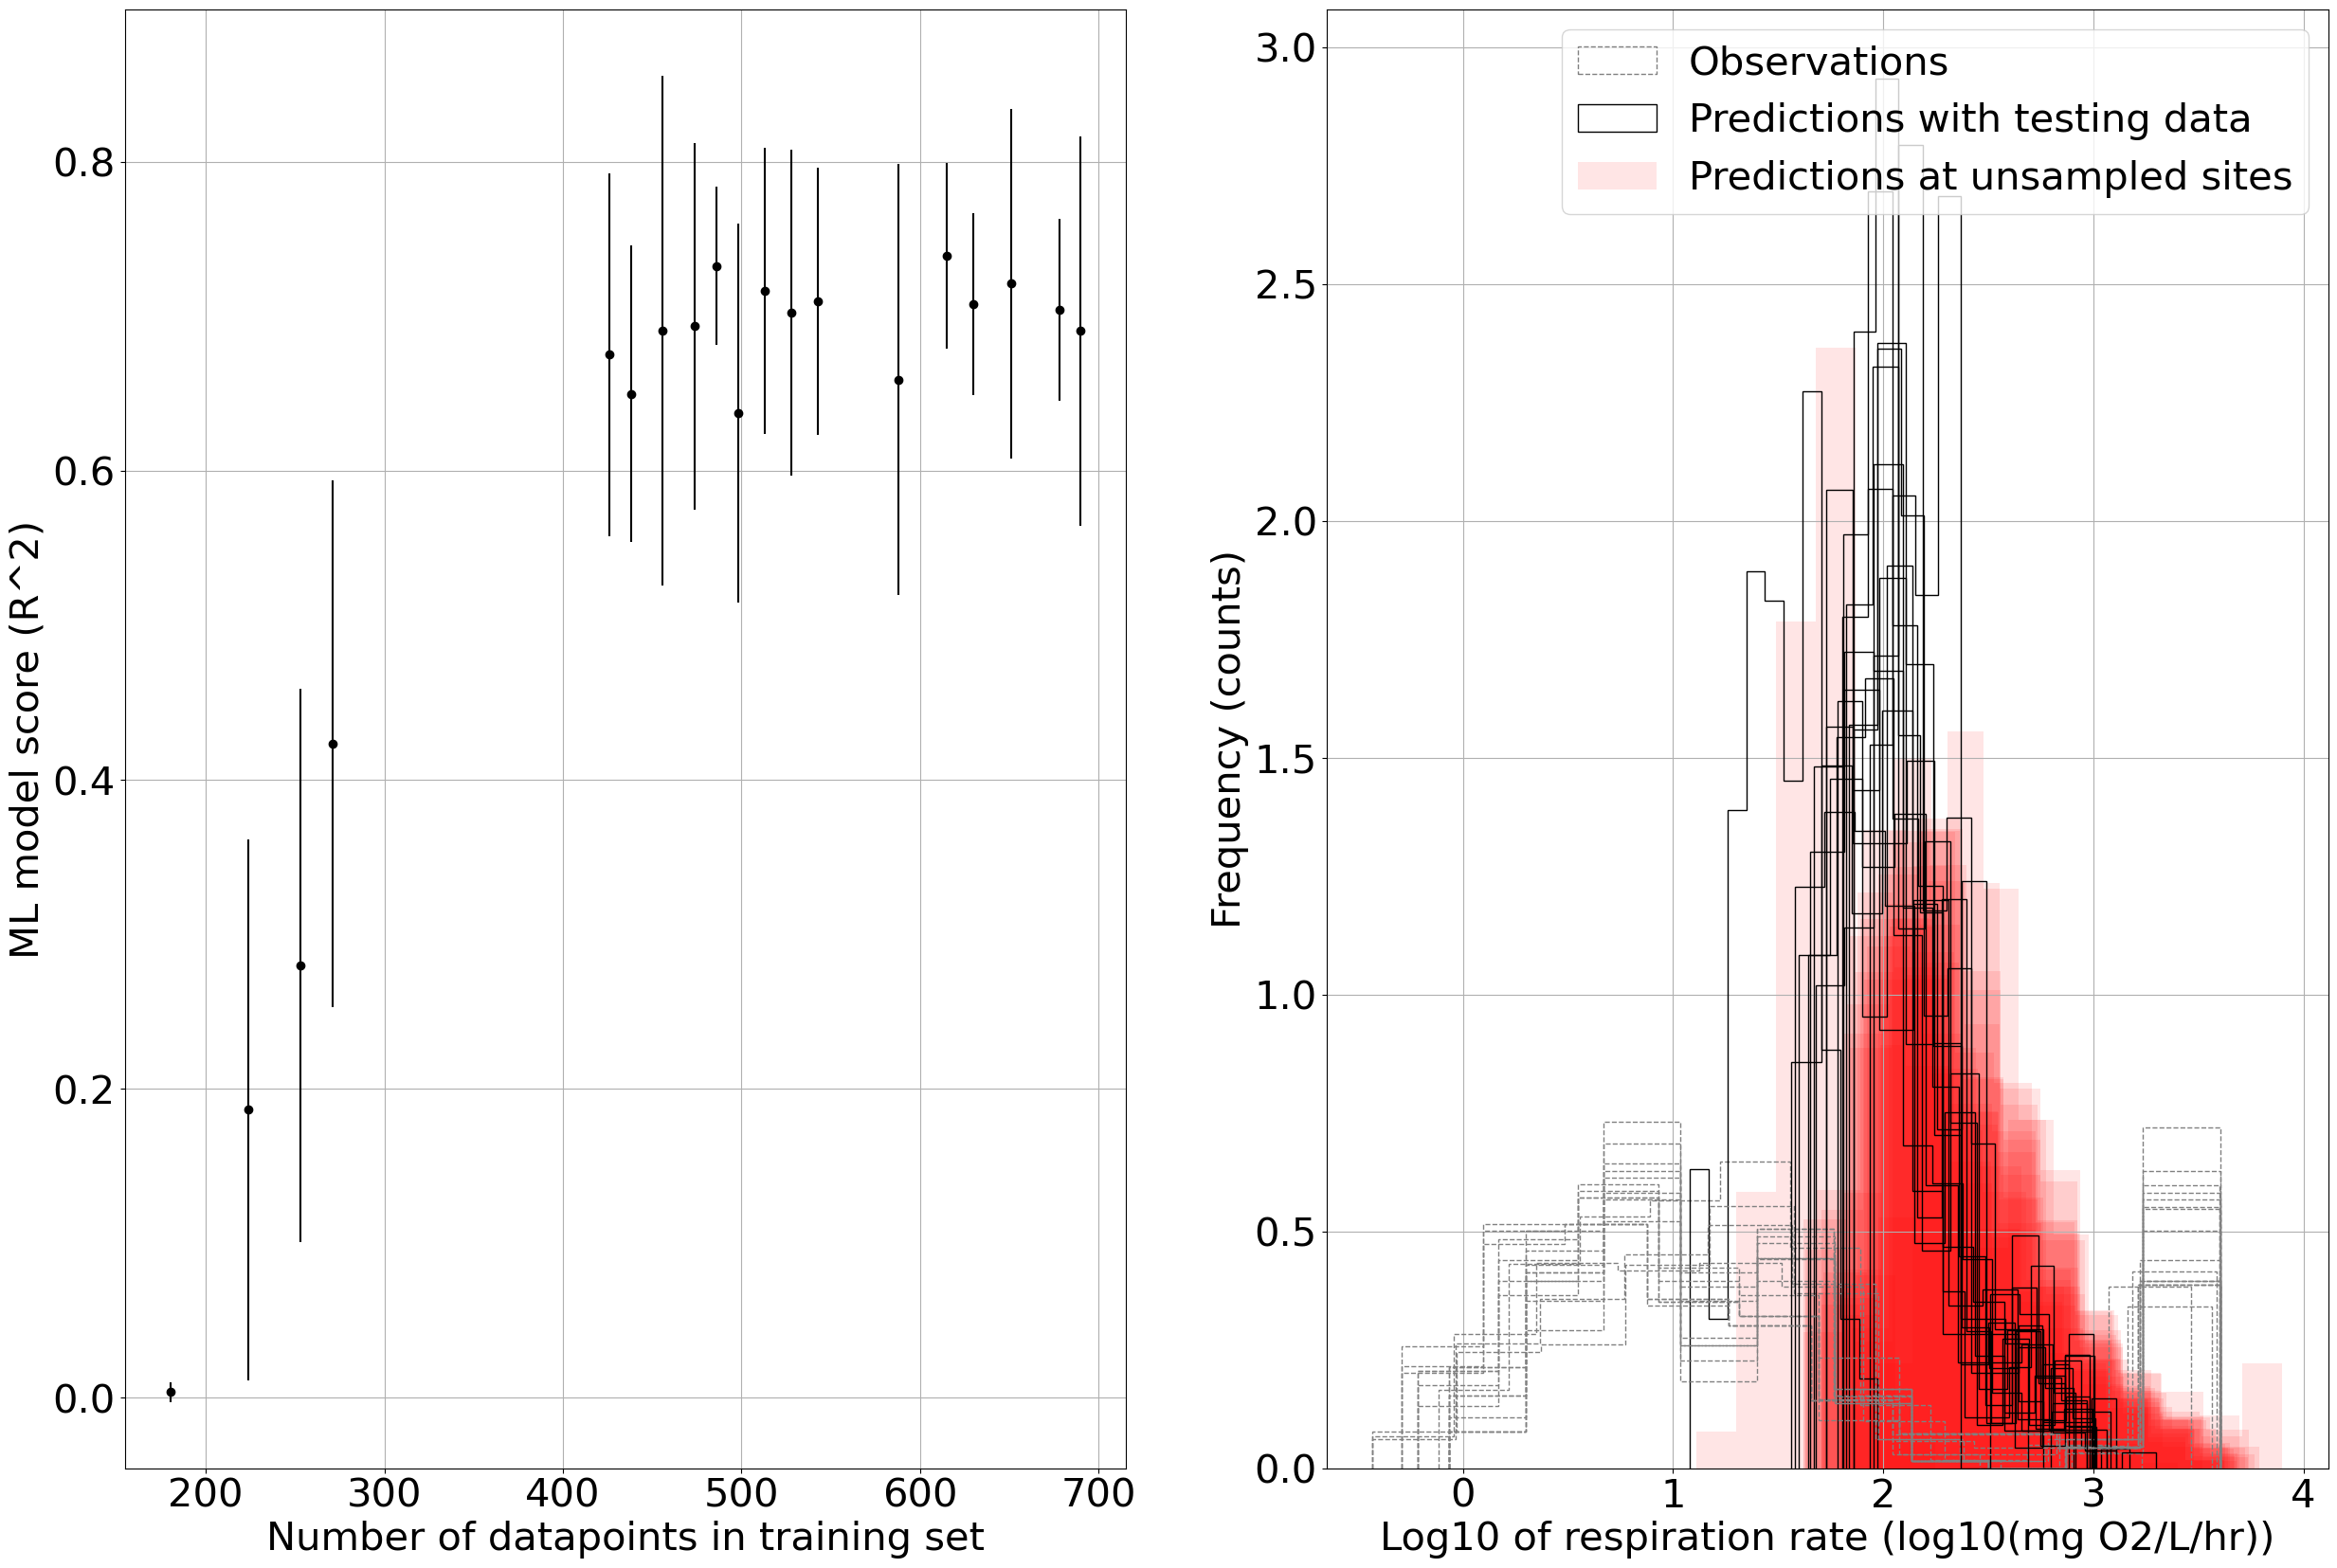

In [4]:
# Set up side-by-side plot
fig, (ax0, ax1)  = plt.subplots(1,2,figsize=(30,20))

# Plot progression of model score with training attempt
ax0.errorbar(model_scores['ntrain'], model_scores['hold-out-avg'],yerr=model_scores['hold-out-std'], fmt='ko')
ax0.grid()
ax0.set_xlabel('Number of datapoints in training set')
ax0.set_ylabel('ML model score (R^2)')

# Plot progression of histograms (for bias) with training attempt
nbin = 10
for bb,branch in enumerate(list_branches):
    # Histogram for training set truth reference
    n, bins, patches = ax1.hist(
            np.log10(np.abs(train_hist[branch])),
            nbin, density=True, histtype="step", linestyle=('dashed'), color=('gray'), alpha=1)
    
    # Histogram for predictions with test data
    n, bins, patches = ax1.hist(
            np.log10(np.abs(test_hist[branch])),
            nbin, density=True, histtype="step", linestyle=('solid'), color=('black'),alpha=1)
    
    # Histogram for predictions
    n, bins, patches = ax1.hist(
            np.log10(np.abs(predict_hist[branch])),
            nbin, density=True, histtype="stepfilled", linestyle=('solid'), color=('red'),alpha=0.1)
    
ax1.grid()
ax1.set_ylabel('Frequency (counts)')
ax1.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))')

ax1.legend(['Observations','Predictions with testing data','Predictions at unsampled sites'])

## Tabulate FPI results

Given a repository and branch name, this part of the notebook will tabulate the FPI results into a ranked list of the most important features, concatenate feature descriptions and data sources, and then save the result as a CSV file for uploading into a document for publication format.
This part has been extended to operate on every branch.

### Load context dictionaries

Here we create some dictorionaries defining the variables. The variable descriptions are based on the `./WHONDRS_v3_CM_SSS_dd.csv` data dictionary (copied from the [source repository](https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1923689)) and an manually transcribed data dictionary `./RiverAtlas_dd.csv` based on the [RiverAtlas data catalog](https://data.hydrosheds.org/file/technical-documentation/RiverATLAS_Catalog_v10.pdf) for RiverAtlas features.

Any feature not in these two data dictionaries will be classified as derived.

In [5]:
WHONDRS_features = pd.read_csv('WHONDRS_v3_CM_SSS_dd.csv',index_col=0)
RiverAtlas_features = pd.read_csv('RiverAtlas_dd.csv',index_col=0)

In [6]:
for ll,table_branch_name in enumerate(list_branches):

    # Load data
    ! cd {repo_prefix}/{repo_name}; git checkout {table_branch_name}
    fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv',index_col=0)
    fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv',index_col=0)
    
    # Consolidate tables

    # Initialize an empty dataframe to store the output table
    FPI_summary = pd.DataFrame(columns=['ID','Importance','std(importance)','Uncertainty in importance','Source','Unit','Definition','num_loop','num_training_samples','id_loop'],index=fpi_avg.index)

    # Compute the mean, std, of the feature importance:
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    mean = fpi_avg.mean(axis=1)
    std = fpi_avg.std(axis=1)
    uncert = fpi_std.max(axis=1)
    
    # Get/insert the iteration number
    
    # Get/insert the iteration ID (branch name)
    
    # Get/insert the number of samples in training
    # PREPROCESSED DATA (actually used)
    input_data = pd.read_csv(repo_prefix+repo_name+'/scripts/prep_06_output_final_train.csv')
    len(input_data.index)

    # Loop over all features and gather information from data dictionaries
    for feature in fpi_avg.index:
    
        # These values are set regardless of the data dictionary
        FPI_summary.loc[feature,'ID'] = feature_id_name_dict[feature]
        FPI_summary.loc[feature,'Importance'] = mean[feature]
        FPI_summary.loc[feature,'std(importance)'] = std[feature]
        FPI_summary.loc[feature,'Uncertainty in importance'] = uncert[feature]
        FPI_summary.loc[feature,'num_loop'] = ll
        FPI_summary.loc[feature,'num_training_samples'] = len(input_data.index)
        FPI_summary.loc[feature,'id_loop'] = table_branch_name
    
        # Assign features based on data dictionary.  Need to relax the assignment
        # to allow for removing all _. and numbers from the variable names due to
        # slight inconsistencies with variable names here and in data dictionaries.
        if feature in WHONDRS_features.index:
            # Assign feature information from this data dictionary
            FPI_summary.loc[feature, 'Source'] = 'WHONDRS'
            FPI_summary.loc[feature, 'Unit'] = WHONDRS_features.loc[feature,'Unit']
            FPI_summary.loc[feature, 'Definition'] = WHONDRS_features.loc[feature,'Definition']
        
        elif feature in RiverAtlas_features.index:
            # Look in RiverAtlas
            FPI_summary.loc[feature, 'Source'] = 'RiverAtlas'
            FPI_summary.loc[feature, 'Unit'] = RiverAtlas_features.loc[feature,'Unit']
            FPI_summary.loc[feature, 'Definition'] = RiverAtlas_features.loc[feature,'Definition']
        
        else:
            # Insert defaults
            print('WARNING! Feature '+feature+' not found in data dictionaries! Fill values inserted.')
            FPI_summary.loc[feature, 'Source'] = 'Derived'
            FPI_summary.loc[feature, 'Units'] = 'UNKNOWN'
            FPI_summary.loc[feature, 'Definition'] = 'UNKNOWN'
            
    # Sort and save data table
    FPI_summary.sort_values(by='Importance',ascending=False).to_csv('./intermediate_branch_data/FPI_summary_table_'+table_branch_name+'.csv')
    
    # Create and/or append a global data table
    if ll == 0:
        # First iteration - just copy
        FPI_summary_all = FPI_summary.copy(deep=True)
    else:
        # Other iterations, append
        FPI_summary_all = pd.concat([FPI_summary_all,FPI_summary],axis='index',ignore_index=False).copy(deep=True)
        

Updating files: 100% (348/348), done.
Switched to branch 'Dec-2021a-log10'
Your branch is up to date with 'origin/Dec-2021a-log10'.
Updating files: 100% (327/327), done.
Switched to branch 'Dec-2021b-log10'
Your branch is up to date with 'origin/Dec-2021b-log10'.
Updating files: 100% (344/344), done.
Switched to branch 'Jul-2022-log10'
Your branch is up to date with 'origin/Jul-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Aug-2022-log10'
Your branch is up to date with 'origin/Aug-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Sep-2022-log10'
Your branch is up to date with 'origin/Sep-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Oct-2022-log10'
Your branch is up to date with 'origin/Oct-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Nov-2022-log10'
Your branch is up to date with 'origin/Nov-2022-log10'.
Updating files: 100% (299/299), done.
Switched to branch 'Dec-2022-log10'
Your branch 

In [7]:
FPI_summary_all

,ID,Importance,std(importance),Uncertainty in importance,Source,Unit,Definition,num_loop,num_training_samples,id_loop
Mean_DO_mg_per_L,20,1.109216,0.229565,1.720813,WHONDRS,milligrams_per_liter,Dissolved oxygen measured during in situ senso...,0,180,Dec-2021a-log10
Mean_DO_percent_saturation,19,1.109216,0.229565,1.720813,WHONDRS,percent_saturation,Dissolved oxygen saturation measured during in...,0,180,Dec-2021a-log10
RA_SO,13,1.152716,0.266847,1.832291,RiverAtlas,non-dim.,Stream order,0,180,Dec-2021a-log10
RA_ms_di,11,1.152716,0.266847,1.832291,RiverAtlas,m/s,Range between annual min and max avg. stream s...,0,180,Dec-2021a-log10
RA_dm,14,1.152716,0.266847,1.832291,RiverAtlas,m,Est. avg. depth of reach derived from other RA...,0,180,Dec-2021a-log10
...,...,...,...,...,...,...,...,...,...,...
ppd_pk_cav,3,1.690409,0.50004,2.419246,RiverAtlas,people/km^2,Average population density over reach catchment,18,690,Nov-2023-log10-DO-update-correct
gla_pc_cse,0,1.006376,0.009772,1.028017,RiverAtlas,percent,Glacier extent over reach catchment,18,690,Nov-2023-log10-DO-update-correct
prm_pc_cse,1,1.031499,0.056316,1.149625,RiverAtlas,percent,Permafrost extent over reach catchment,18,690,Nov-2023-log10-DO-update-correct
pH,5,1.908155,0.764047,3.873448,WHONDRS,pH,pH.,18,690,Nov-2023-log10-DO-update-correct


In [8]:
FPI_summary_all.to_csv('FPI_summary_table_ALL.csv')